In [2]:
import exercise2_config as config
import pandas as pd
import numpy as np


train_images = pd.read_csv(config.TRAIN_DATA_FILE, header=None)
test_images = pd.read_csv(config.TEST_DATA_FILE, header=None)

train_data = np.array(train_images.iloc[:,1:])
train_labels = np.array(train_images.iloc[:,0])
test_data = np.array(test_images.iloc[:,1:])
test_labels = np.array(test_images.iloc[:,0]) 

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import ConvergenceWarning
from datetime import datetime
ConvergenceWarning('ignore')


def algorithm_pipeline(X_train_data, y_train_data, 
                       model, param_grid, cv=5, scoring_fit='accuracy'):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2,
        return_train_score=True # set this for train score
    )
    return gs.fit(X_train_data, y_train_data)


random_state = round(datetime.timestamp(datetime.now()))
print(f'random_state = {random_state}')
mlp = MLPClassifier(random_state=random_state, verbose=2)
parameter_space = {
    'max_iter' : np.linspace(10, 100, num=5, dtype=int),
    'hidden_layer_sizes' : np.linspace(10, 100, num=10, dtype=int),
    'activation' : ['logistic'],
    'solver' : ['sgd'],
    'learning_rate_init' : np.linspace(0.001, 0.1, num=10), #  Only used when solver=’sgd’ or ‘adam’.
    'learning_rate' : ['constant'] # Only used when solver='sgd'
}
clf = algorithm_pipeline(train_data, train_labels, mlp, parameter_space, 4)

In [ ]:
print(f'random_state = {random_state}')
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_score_)
print(clf.score(test_data, test_labels))

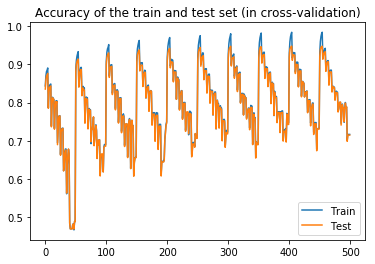

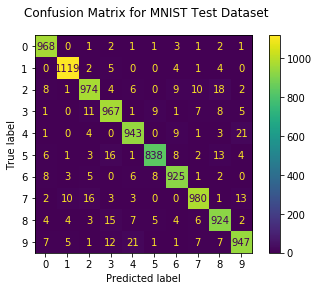

In [5]:
# This is not the final plot (the one included in the report)
# x axis represents the different configurations tried by GridSearchCV

from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

plt.plot(clf.cv_results_['mean_train_score'], label='Train')
plt.plot(clf.cv_results_['mean_test_score'], label='Test')
plt.legend()
plt.title("Accuracy of the train and test set (in cross-validation)")
plt.show()

fig=plot_confusion_matrix(clf, test_data, test_labels, display_labels=["0","1","2","3","4","5","6","7","8","9"])
fig.figure_.suptitle("Confusion Matrix for MNIST Test Dataset")
plt.show()

In [ ]:
# Rerun the MLP Classifier using the best 10 configuration found (out of 500)
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning
from datetime import datetime
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from warnings import simplefilter

simplefilter("ignore", category=ConvergenceWarning)
ConvergenceWarning('ignore')

random_state = round(datetime.timestamp(datetime.now()))
print(f'random_state = {random_state}')

configurations = [
  {'hidden_layer_sizes': 60, 'max_iter': 100, 'learning_rate_init': 0.001},
  {'hidden_layer_sizes': 70, 'max_iter': 77, 'learning_rate_init': 0.001},
  {'hidden_layer_sizes': 70, 'max_iter': 100, 'learning_rate_init': 0.001},
  {'hidden_layer_sizes': 80, 'max_iter': 77, 'learning_rate_init': 0.001},
  {'hidden_layer_sizes': 80, 'max_iter': 100, 'learning_rate_init': 0.001},
  {'hidden_layer_sizes': 90, 'max_iter': 77, 'learning_rate_init': 0.001},
  {'hidden_layer_sizes': 90, 'max_iter': 100, 'learning_rate_init': 0.001},
  {'hidden_layer_sizes': 100, 'max_iter': 55, 'learning_rate_init': 0.001},
  {'hidden_layer_sizes': 100, 'max_iter': 77, 'learning_rate_init': 0.001},
  {'hidden_layer_sizes': 100, 'max_iter': 100, 'learning_rate_init': 0.001},
]


best_configuration = None
best_score = None

# TODO: remove
train_data = train_data[:100]
train_labels = train_labels[:100]
test_data = test_data[:100]
test_labels = test_labels[:100]

# Use cross-validation to select best configuration
# https://scikit-learn.org/stable/modules/cross_validation.html#k-fold
kf = KFold(n_splits=5, random_state=random_state, shuffle=True)
for configuration in configurations:
  print(f'configuration = {configuration}')
  scores = []

  for fold_train_index, fold_validation_index in kf.split(train_data, train_labels):
    fold_train_data = train_data[fold_train_index]
    fold_train_labels = train_labels[fold_train_index]
    fold_validation_data = train_data[fold_validation_index]
    fold_validation_labels = train_labels[fold_validation_index]

    # TODO: make sure max_iter is set properlu
    mlp = MLPClassifier(random_state=random_state, 
                        verbose=0,
                        activation='logistic',
                        solver='sgd',
                        learning_rate='constant',
                        hidden_layer_sizes=configuration['hidden_layer_sizes'],
                        max_iter=int(configuration['max_iter'] / 10),
                        learning_rate_init=configuration['learning_rate_init'])
    mlp.fit(fold_train_data, fold_train_labels)
    scores.append(mlp.score(fold_validation_data, fold_validation_labels))

  print(f'scores = {scores}')
  average_score = sum(scores) / len(scores)
  print(f'average_score = {average_score}')
  if best_score is None or average_score > best_score:
    best_score = average_score
    best_configuration = configuration
  print('==================================================')

print(f'best_configuration = {best_configuration}')
print(f'best_score = {best_score}')

In [55]:
# NOT FINISHED/NOT WORKING
# Run the algorithm once again using the best configuration found
from sklearn.metrics import log_loss
from sklearn import metrics


# Trains a MLPClassifier witht the given configuration.
# Returns the train and test accuraccy and loss per each iteration/epoch.
def TrainBestClassifier(configuration):
  train_accuracy_per_epoch = []
  test_accuracy_per_epoch = []
  train_loss_per_epoch = []
  test_loss_per_epoch = []
  
  classes = np.unique(train_labels)
  mlp = MLPClassifier(random_state=random_state, 
                      verbose=0,
                      activation='logistic',
                      solver='sgd',
                      learning_rate='constant',
                      batch_size=len(train_data),
                      max_iter=10,
                      hidden_layer_sizes=configuration['hidden_layer_sizes'],
                      learning_rate_init=configuration['learning_rate_init'])
  # for _ in range(configuration['max_iter']):
  for _ in range(5):
    mlp.partial_fit(train_data, train_labels, classes)
    train_accuracy_per_epoch.append(mlp.score(train_data, train_labels))
    test_accuracy_per_epoch.append(mlp.score(test_data, test_labels))
    train_loss_per_epoch.append(mlp.loss_)  
    
    print('=====')
    print(mlp.loss_curve_)
    train_predictions = mlp.predict_log_proba(train_data)
    print(mlp.coefs_)
    loss = log_loss(y_true=train_labels, y_pred=train_predictions)
    print(loss)
    # Add L2 regularization term to loss
    values = 0
    for s in mlp.coefs_:
        s = s.ravel()
        values += np.dot(s, s)
    loss += (0.5 * mlp.alpha) * values / len(train_data)
    print(loss / train_data.shape[0])

    input()


  # #   train_loss_per_epoch.append(mlp.loss_)
  # #   input()

  # mlp.fit(train_data, train_labels)
  # print(mlp.loss_curve_)
  # print(mlp.loss_)
  # mlp.score(test_data, test_labels)
  # print(mlp.loss_curve_)
  # print(mlp.validation_scores_)


  print(mlp.get_params(deep=True).keys())
  
  return train_accuracy_per_epoch, test_accuracy_per_epoch, train_loss_per_epoch, test_loss_per_epoch

train_accuracy_per_epoch, test_accuracy_per_epoch, train_loss_per_epoch, test_loss_per_epoch = TrainBestClassifier(best_configuration)

print(f'Accuracy on train data: {train_accuracy_per_epoch[-1]}')
print(f'Accuracy on test data: {test_accuracy_per_epoch[-1]}')

=====
[2.313174042203155]
[array([[ 0.00072468,  0.03930992, -0.03874916, ..., -0.04022393,
         0.03676721,  0.02319368],
       [-0.03811622, -0.00190418,  0.02839644, ..., -0.04609718,
        -0.04809833,  0.00888783],
       [ 0.04554481,  0.0086601 ,  0.00984319, ..., -0.01126569,
         0.00700612, -0.01746197],
       ...,
       [-0.02641117,  0.0296708 , -0.00772726, ..., -0.00251953,
         0.00395728, -0.02529118],
       [-0.02444354,  0.0013724 ,  0.03174857, ..., -0.02417581,
         0.00346374,  0.02121847],
       [ 0.04240355, -0.0292258 ,  0.02536862, ..., -0.04615447,
        -0.03168154,  0.03582725]]), array([[-1.25564945e-01, -1.55499514e-01,  7.78394765e-02,
         8.60362343e-02,  5.92913777e-02,  4.80327003e-02,
        -4.27893080e-02, -8.49193893e-02, -1.28995684e-01,
        -1.91128634e-02],
       [-2.27218359e-02,  7.12072273e-02,  9.89177337e-02,
        -1.56673353e-01,  1.17552826e-01,  1.25339702e-01,
        -1.50024715e-01, -1.26873830e-

In [ ]:
# Plot accuracy and loss for the best configuration
# You need to install ipympl to make this work
%matplotlib widget
import matplotlib
from matplotlib import pyplot as plt
import os


epochs = [i for i in range(1, len(train_accuracy_per_epoch) + 1)]
fig, axes = plt.subplots(2, 1, constrained_layout=True)
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False


# Show accuracy
axes[0].plot(epochs, train_accuracy_per_epoch,'-o')
axes[0].plot(epochs, test_accuracy_per_epoch, '-o')
axes[0].set_xticks(epochs)
axes[0].legend(['Train', 'Test'])
axes[0].set_title('Accuracy')


# Show loss
axes[1].plot(epochs, train_loss_per_epoch,'-o')
axes[1].plot(epochs, test_loss_per_epoch, '-o')
axes[1].set_xticks(epochs)
axes[1].legend(['Train', 'Test'])
axes[1].set_title('Loss')


# Save as png
plot_filename = os.path.join(os.path.abspath(''), 'mlp_model.png')
plt.savefig(plot_filename)

# Report

In [19]:
#This generates pdf with results
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
def pd_dataframe_to_pdf(df, pdfName):
    fig, ax =plt.subplots(figsize=(12,4))
    ax.axis('tight')
    ax.axis('off')
    the_table = ax.table(cellText=df.values,colLabels=df.columns,loc='center')

    pp = PdfPages(pdfName)
    pp.savefig(fig, bbox_inches='tight')
    pp.close()
    

In [20]:
#Transfer results to panda dataframe and call function above
df = pd.DataFrame(columns=['Hidden Layer Size', 'Learning Rate', 'Max Iterations / Epochs', 'Accuracy'])

for index in range(len(clf.cv_results_['param_hidden_layer_sizes'])):
    dicts = {'Hidden Layer Size' : clf.cv_results_['param_hidden_layer_sizes'][index] , 'Learning Rate' : clf.cv_results_['param_learning_rate_init'][index], 'Max Iterations / Epochs' :clf.cv_results_['param_max_iter'][index], 'Accuracy' : clf.cv_results_['mean_test_score'][index]}
    df=df.append(dicts,ignore_index=True)

pd_dataframe_to_pdf(df, "table_with_results_Ex2b.pdf")